Initialisation PySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, greatest

In [2]:
spark = SparkSession.builder \
    .appName("ExtremeWeatherETL") \
    .getOrCreate()

Chargement du dataset CSV

In [3]:
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("C:\\Users\\Lenovo\\Downloads\\Projett_globale_Modele\\df_weather_clean_multi_cities.csv")


In [4]:
df.printSchema()
df.show(5)

root
 |-- datetime: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_direction: double (nullable = true)

+-------------------+-----------+-------------+--------+--------+----------+--------------+
|           datetime|       city|  temperature|humidity|pressure|wind_speed|wind_direction|
+-------------------+-----------+-------------+--------+--------+----------+--------------+
|2012-10-01 13:00:00|Los Angeles|       291.87|    88.0|  1013.0|       0.0|           0.0|
|2012-10-01 14:00:00|Los Angeles|291.868185522|    88.0|  1013.0|       0.0|           0.0|
|2012-10-01 15:00:00|Los Angeles|291.862844459|    88.0|  1013.0|       0.0|           0.0|
|2012-10-01 16:00:00|Los Angeles|291.857503395|    88.0|  1013.0|       0.0|           0.0|
|2012-10-01 17:00:00|Los Angeles|291.852162332|    88.0|  10

In [5]:
df.groupBy("city").count().orderBy("count", ascending=False).show(truncate=False)


+-------------+-----+
|city         |count|
+-------------+-----+
|Portland     |45252|
|Seattle      |45248|
|Los Angeles  |45247|
|San Francisco|44459|
|Vancouver    |44437|
+-------------+-----+



In [6]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "city",
    when(col("city") == "Los Angeles", "Agadir")      # méditerranéen / côtier
    .when(col("city") == "San Francisco", "Rabat")   # océanique frais
    .when(col("city") == "Seattle", "Tanger")        # océanique humide
    .when(col("city") == "Vancouver", "Casablanca")  # océanique tempéré
    .when(col("city") == "Portland", "Tetouan")       
    .otherwise("Fès")                                # continental
)

In [7]:
df.groupBy("city").count().orderBy("count", ascending=False).show(truncate=False)

+----------+-----+
|city      |count|
+----------+-----+
|Tetouan   |45252|
|Tanger    |45248|
|Agadir    |45247|
|Rabat     |44459|
|Casablanca|44437|
+----------+-----+



Nettoyage & préparation

In [8]:
print("Nombre de lignes :", df.count())
print("Nombre de colonnes :", len(df.columns))
print("Colonnes :", df.columns)

Nombre de lignes : 224643
Nombre de colonnes : 7
Colonnes : ['datetime', 'city', 'temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction']


In [9]:
df.describe([
    "temperature", "humidity",'pressure',"wind_speed", 'wind_direction'
]).show()


+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|      temperature|          humidity|          pressure|        wind_speed|    wind_direction|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|           224643|            224643|            224643|            224643|            224643|
|   mean|286.4566954253717| 74.59249342289766|1018.7580138263824|2.1174329936833107|171.91649862225842|
| stddev|7.045966733910661|19.466715384102223| 11.56376210344364|1.9264352821231236|104.12152028288119|
|    min|           245.15|               5.0|             849.0|               0.0|               0.0|
|    max|           315.47|             100.0|            1100.0|              19.0|             360.0|
+-------+-----------------+------------------+------------------+------------------+------------------+



In [10]:
from pyspark.sql.functions import col

df = df.withColumn(
    "temperature",
    col("temperature") - 273.15
)


In [11]:
from pyspark.sql.functions import col, sum

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show()

+--------+----+-----------+--------+--------+----------+--------------+
|datetime|city|temperature|humidity|pressure|wind_speed|wind_direction|
+--------+----+-----------+--------+--------+----------+--------------+
|       0|   0|          0|       0|       0|         0|             0|
+--------+----+-----------+--------+--------+----------+--------------+



In [12]:
df.select("temperature").summary().show()

+-------+------------------+
|summary|       temperature|
+-------+------------------+
|  count|            224643|
|   mean|13.306695425370746|
| stddev| 7.045966733910599|
|    min|-27.99999999999997|
|    25%|  8.40833333300003|
|    50%|13.100000000000023|
|    75%|             17.75|
|    max| 42.32000000000005|
+-------+------------------+



In [13]:
df.select("humidity").summary().show()

+-------+------------------+
|summary|          humidity|
+-------+------------------+
|  count|            224643|
|   mean| 74.59249342289766|
| stddev|19.466715384102223|
|    min|               5.0|
|    25%|              63.0|
|    50%|              78.0|
|    75%|              89.0|
|    max|             100.0|
+-------+------------------+



In [14]:
df.select("pressure").summary().show()

+-------+------------------+
|summary|          pressure|
+-------+------------------+
|  count|            224643|
|   mean|1018.7580138263824|
| stddev| 11.56376210344364|
|    min|             849.0|
|    25%|            1013.0|
|    50%|            1018.0|
|    75%|            1024.0|
|    max|            1100.0|
+-------+------------------+



In [15]:
df.select("wind_speed").summary().show()

+-------+------------------+
|summary|        wind_speed|
+-------+------------------+
|  count|            224643|
|   mean|2.1174329936833107|
| stddev|1.9264352821231236|
|    min|               0.0|
|    25%|               1.0|
|    50%|               2.0|
|    75%|               3.0|
|    max|              19.0|
+-------+------------------+



In [16]:
df.count() - df.dropDuplicates(["datetime", "city"]).count()
#df = df.dropDuplicates(["datetime", "city"])

25

In [17]:
df.count() - df.dropDuplicates(["datetime","temperature", "humidity", "pressure", "wind_speed", "wind_direction", "city"]).count()
#df = df.dropDuplicates(["datetime", "temperature", "humidity","pressure", "wind_speed", "wind_direction", "city"])

0

In [18]:
df_grouped = df.groupBy("city").count()
df_grouped.show()

+----------+-----+
|      city|count|
+----------+-----+
|    Agadir|45247|
|   Tetouan|45252|
|     Rabat|44459|
|Casablanca|44437|
|    Tanger|45248|
+----------+-----+



In [19]:
df_grouped = df.groupBy(["datetime", "city"]).count()
df_grouped.show()

+-------------------+-------+-----+
|           datetime|   city|count|
+-------------------+-------+-----+
|2012-10-15 00:00:00| Agadir|    1|
|2012-10-23 17:00:00| Agadir|    1|
|2012-10-23 20:00:00| Agadir|    1|
|2012-11-05 23:00:00| Agadir|    1|
|2012-11-12 19:00:00| Agadir|    1|
|2012-10-09 01:00:00|Tetouan|    1|
|2012-10-10 04:00:00|Tetouan|    1|
|2012-10-18 11:00:00|Tetouan|    1|
|2012-10-18 22:00:00|Tetouan|    1|
|2012-10-21 01:00:00|Tetouan|    1|
|2012-11-10 03:00:00|Tetouan|    1|
|2012-11-13 03:00:00|Tetouan|    1|
|2012-11-23 02:00:00| Agadir|    1|
|2012-11-25 16:00:00| Agadir|    1|
|2012-12-30 04:00:00| Agadir|    1|
|2013-02-12 15:00:00| Agadir|    1|
|2013-02-14 20:00:00| Agadir|    1|
|2013-02-16 17:00:00| Agadir|    1|
|2013-02-16 22:00:00| Agadir|    1|
|2013-02-24 04:00:00| Agadir|    1|
+-------------------+-------+-----+
only showing top 20 rows



In [20]:
from pyspark.sql.functions import max, min, avg, sum

df_daily = df.groupBy("datetime").agg(
    max("temperature").alias("temp_max"),
    min("temperature").alias("temp_min"),
    avg("humidity").alias("humidity"),
    sum("pressure").alias("pressure"),
    max("wind_speed").alias("wind_speed"),
    max("wind_direction").alias("wind_direction"),
    )
df_daily.show(5)

+-------------------+------------------+-----------------+--------+-----------------+----------+--------------+
|           datetime|          temp_max|         temp_min|humidity|         pressure|wind_speed|wind_direction|
+-------------------+------------------+-----------------+--------+-----------------+----------+--------------+
|2012-10-20 02:00:00|             22.25|9.689999999999998|    69.2|           5063.0|       6.0|         290.0|
|2012-11-16 17:00:00|12.980000000000018|2.840000000000032|    76.8|           5051.0|       3.0|          71.0|
|2012-11-22 17:00:00|              15.0|4.470000000000027|    85.0|      5072.390625|       6.0|         300.0|
|2012-12-10 19:00:00| 16.83000000000004|2.400000000000034|    79.2|5108.666666666666|       4.0|         150.0|
|2012-12-14 08:00:00|12.950000000000045| 4.28000000000003|    87.2|         5071.125|       2.0|         250.0|
+-------------------+------------------+-----------------+--------+-----------------+----------+--------

In [21]:
print("Nombre de jours :", df_daily.count())

Nombre de jours : 45247


Distribution des variables

+----------+-----+
|      city|count|
+----------+-----+
|   Tetouan|45252|
|    Tanger|45248|
|    Agadir|45247|
|     Rabat|44459|
|Casablanca|44437|
+----------+-----+



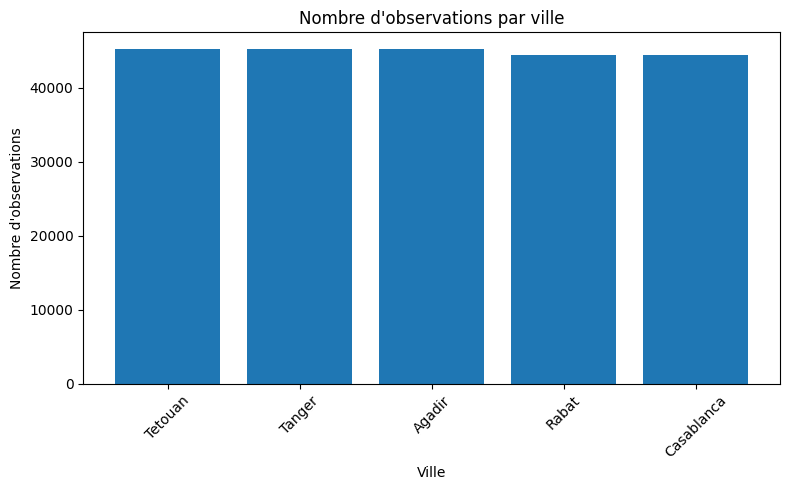

In [22]:
from pyspark.sql.functions import col

df_city_count = (
    df.groupBy("city")
      .count()
      .orderBy(col("count").desc())
)

df_city_count.show()
pdf_city = df_city_count.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(pdf_city["city"], pdf_city["count"])
plt.xlabel("Ville")
plt.ylabel("Nombre d'observations")
plt.title("Nombre d'observations par ville")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+----------+-----------------+
|      city|    humidity_mean|
+----------+-----------------+
|Casablanca|81.83540743074465|
|    Tanger|77.09874469589816|
|     Rabat|76.83988618727366|
|   Tetouan|74.66992619110758|
|    Agadir|62.68723893296793|
+----------+-----------------+



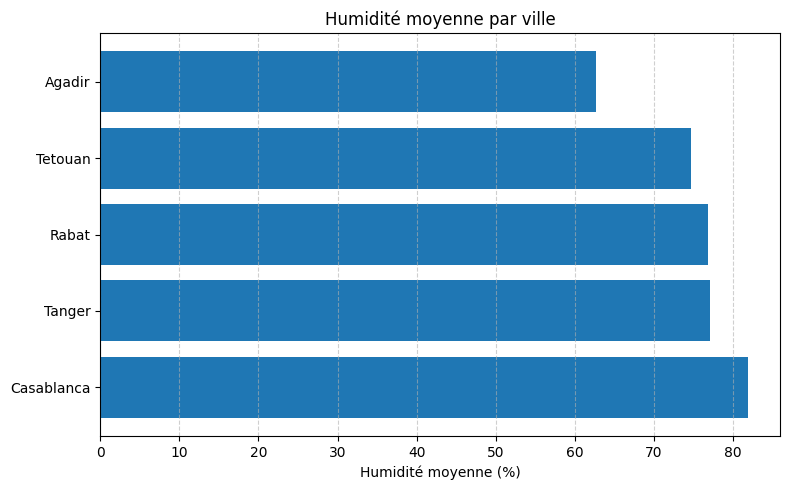

In [23]:
from pyspark.sql.functions import col, avg

df_humidity_city = (
    df.groupBy("city")
      .agg(avg("humidity").alias("humidity_mean"))
      .orderBy(col("humidity_mean").desc())
)

df_humidity_city.show()
pdf_humidity = df_humidity_city.toPandas()
plt.figure(figsize=(8,5))
plt.barh(pdf_humidity["city"], pdf_humidity["humidity_mean"])
plt.xlabel("Humidité moyenne (%)")
plt.title("Humidité moyenne par ville")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




+----------+------------------+
|      city|     pressure_mean|
+----------+------------------+
|    Tanger|1020.9982982673267|
|   Tetouan|1019.2681980906922|
|     Rabat|1018.8418880316697|
|Casablanca|1018.8106645363098|
|    Agadir|1015.8733175680155|
+----------+------------------+



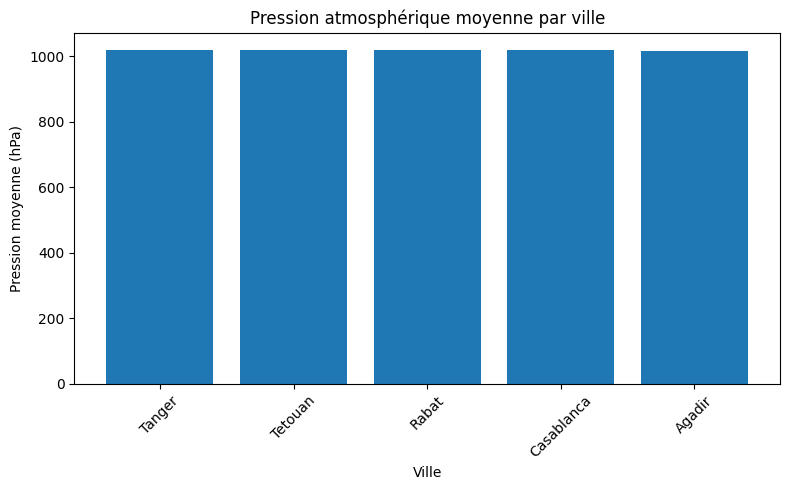

In [24]:
from pyspark.sql.functions import col, avg

df_pressure_city = (
    df.groupBy("city")
      .agg(avg("pressure").alias("pressure_mean"))
      .orderBy(col("pressure_mean").desc())
)

df_pressure_city.show()
pdf_pressure = df_pressure_city.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(pdf_pressure["city"], pdf_pressure["pressure_mean"])
plt.xlabel("Ville")
plt.ylabel("Pression moyenne (hPa)")
plt.title("Pression atmosphérique moyenne par ville")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



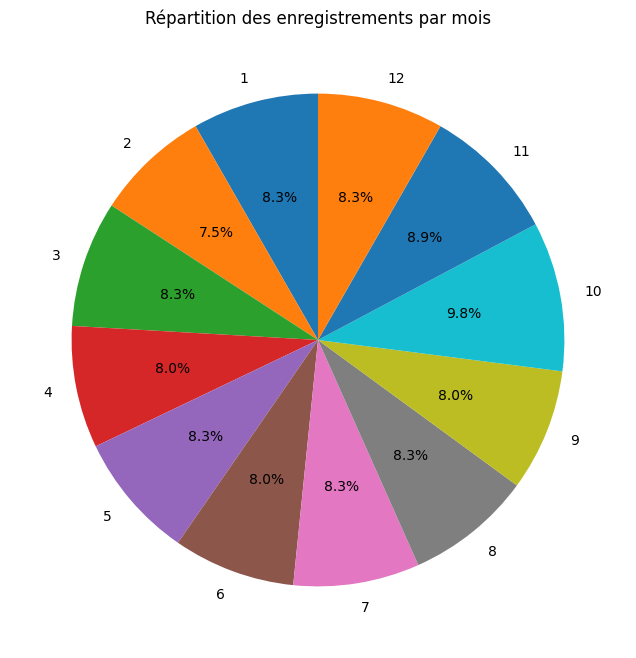

In [25]:
from pyspark.sql.functions import col, month  
df_month = df.withColumn("month", month(col("datetime")))

df_month_count = df_month.groupBy("month").count().orderBy("month")

pdf_month = df_month_count.toPandas()

plt.figure(figsize=(8,8))
plt.pie(pdf_month["count"], labels=pdf_month["month"], autopct='%1.1f%%', startangle=90)
plt.title("Répartition des enregistrements par mois")
plt.show()


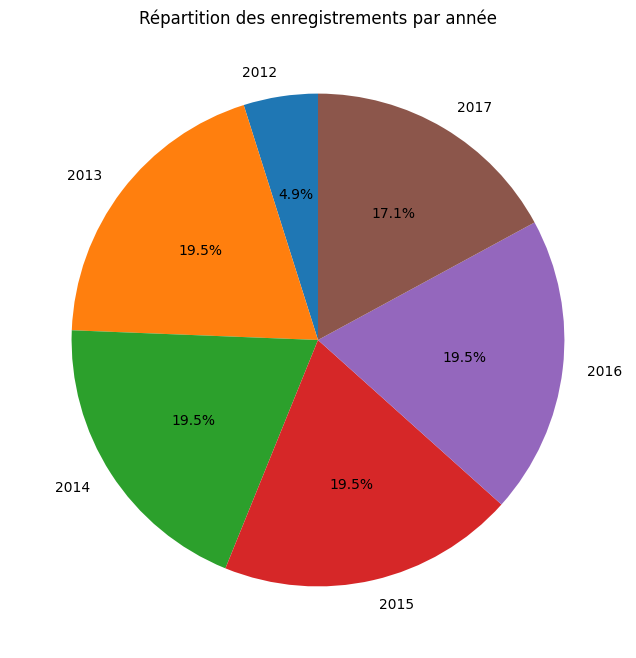

In [26]:
from pyspark.sql.functions import col, year

df_year = df.withColumn("year", year(col("datetime")))

df_year_count = df_year.groupBy("year").count().orderBy("year")

pdf_year = df_year_count.toPandas()

plt.figure(figsize=(8,8))
plt.pie(pdf_year["count"], labels=pdf_year["year"], autopct='%1.1f%%', startangle=90)
plt.title("Répartition des enregistrements par année")
plt.show()


In [27]:
from pyspark.sql.functions import col

df_fixed = df.withColumn("datetime", col("datetime").cast("string"))
sample_df = df_fixed.toPandas()


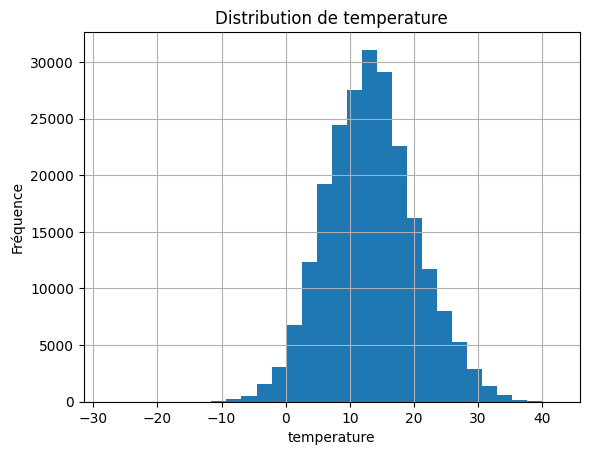

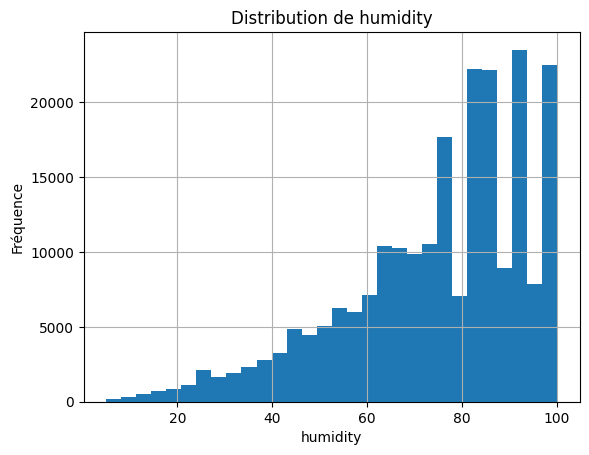

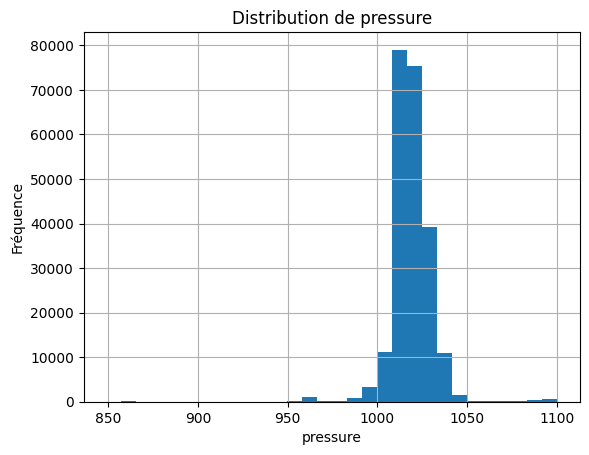

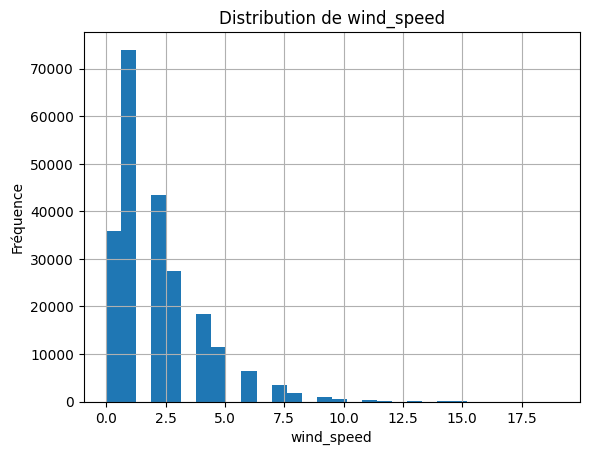

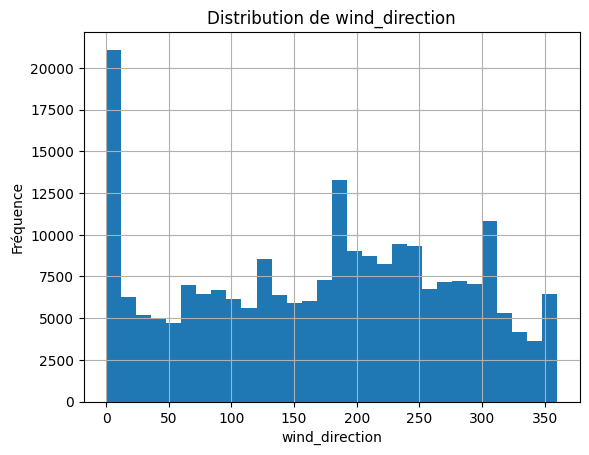

In [28]:
import matplotlib.pyplot as plt

features = [
    "temperature",
    "humidity",
    "pressure",
    "wind_speed",
    "wind_direction"
]

for f in features:
    plt.figure()
    sample_df[f].hist(bins=30)
    plt.title(f"Distribution de {f}")
    plt.xlabel(f)
    plt.ylabel("Fréquence")
    plt.show()


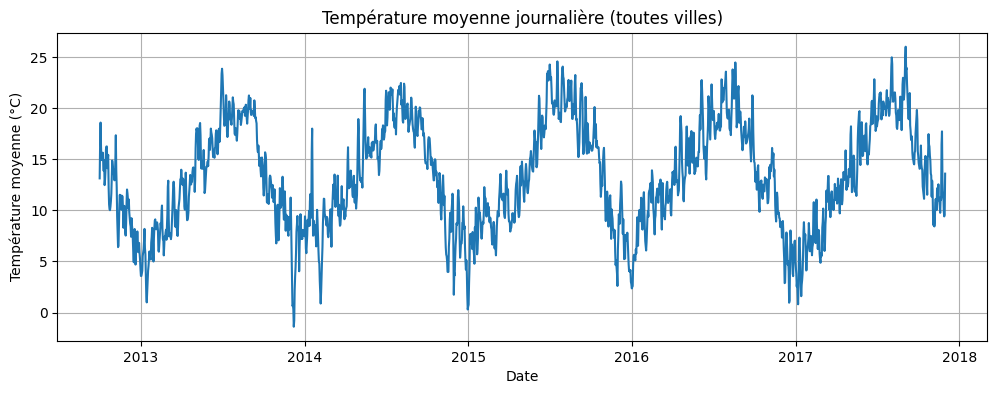

In [29]:
from pyspark.sql.functions import to_date, avg

df_daily = (
    df.withColumn("date", to_date("datetime"))
      .groupBy("date")
      .agg(avg("temperature").alias("temp_mean"))
      .orderBy("date")
)
pdf_daily = df_daily.toPandas()

plt.figure(figsize=(12,4))
plt.plot(pdf_daily["date"], pdf_daily["temp_mean"])
plt.title("Température moyenne journalière (toutes villes)")
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.grid(True)
plt.show()


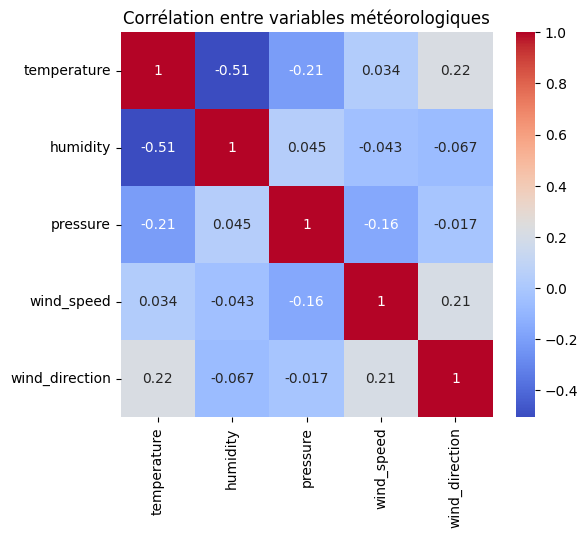

In [30]:
import seaborn as sns

corr = sample_df[features].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Corrélation entre variables météorologiques")
plt.show()


L’analyse de corrélation montre une relation négative marquée entre la température et l’humidité, phénomène cohérent d’un point de vue météorologique. Les autres variables présentent des corrélations faibles, indiquant une faible redondance et justifiant leur utilisation conjointe pour la détection d’événements climatiques extrêmes.

Analyse saisonnière

In [31]:
from pyspark.sql.functions import month, when

df = df.withColumn("month", month("datetime"))

df = df.withColumn(
    "season",
    when(col("month").isin([12,1,2]), "winter")
    .when(col("month").isin([3,4,5]), "spring")
    .when(col("month").isin([6,7,8]), "summer")
    .otherwise("autumn")
)


In [32]:
df.groupBy("season").agg(
    {"temperature": "avg",
     "humidity": "avg",
     "pressure": "avg",
     "wind_speed": "avg"}
).show()


+------+------------------+-----------------+------------------+------------------+
|season|  avg(temperature)|    avg(humidity)|   avg(wind_speed)|     avg(pressure)|
+------+------------------+-----------------+------------------+------------------+
|winter|7.2918914798344145|78.47617243800583| 2.131860009608633|1020.6247260066837|
|summer|19.408488095073782|70.39423007246377|1.9960144927536232|1016.5991666666666|
|spring|12.633693350817198|73.02918742639731|2.3102998460005435|1020.6869046647395|
|autumn|13.736373690162202|76.38617162813904|2.0388741061034423|1017.2892046399468|
+------+------------------+-----------------+------------------+------------------+



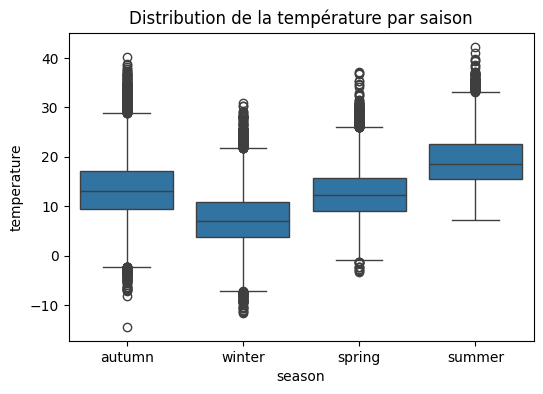

In [33]:
season_df = df.select("season", "temperature").sample(0.3).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x="season", y="temperature", data=season_df)
plt.title("Distribution de la température par saison")
plt.show()


In [34]:
df.groupBy("city").agg(
    {"temperature": "avg",
     "pressure": "avg",
     "humidity": "avg",
     "wind_speed": "avg"}
).show()


+----------+------------------+-----------------+------------------+------------------+
|      city|  avg(temperature)|    avg(humidity)|   avg(wind_speed)|     avg(pressure)|
+----------+------------------+-----------------+------------------+------------------+
|    Agadir|17.695646270145176|62.68723893296793|1.2178928989767277|1015.8733175680155|
|   Tetouan|11.842929189358104|74.66992619110758|2.0507380889242466|1019.2681980906922|
|     Rabat|15.005533661270732|76.83988618727366| 2.785858881216402|1018.8418880316697|
|Casablanca|10.712092028241887|81.83540743074465|2.4334676058239757|1018.8106645363098|
|    Tanger|11.260621187102968|77.09874469589816|2.1165134370579914|1020.9982982673267|
+----------+------------------+-----------------+------------------+------------------+



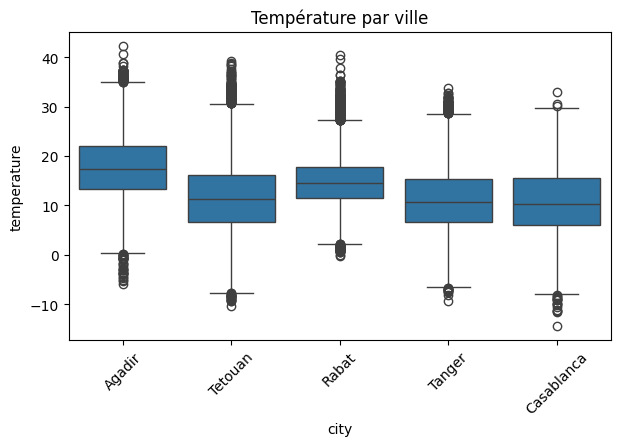

In [35]:
city_df = df.select("city", "temperature").sample(0.3).toPandas()

plt.figure(figsize=(7,4))
sns.boxplot(x="city", y="temperature", data=city_df)
plt.xticks(rotation=45)
plt.title("Température par ville")
plt.show()


In [36]:
print("Nombre de lignes :", df_daily.count())


Nombre de lignes : 1887


logique floue + LSTM  

Fonctions d’appartenance floues (μ)

In [37]:
from pyspark.sql.functions import to_date, avg, max as spark_max

df_daily = (
    df.withColumn("date", to_date("datetime"))
      .groupBy("city", "date")
      .agg(
          avg("temperature").alias("temp_mean"),
          avg("humidity").alias("humidity_mean"),
          avg("pressure").alias("pressure_mean"),
          avg("wind_speed").alias("wind_mean"),
          spark_max("temperature").alias("temp_max"),
          spark_max("wind_speed").alias("wind_max")
      )
)

df_daily.show(5)

+------+----------+------------------+------------------+-----------------+------------------+------------------+--------+
|  city|      date|         temp_mean|     humidity_mean|    pressure_mean|         wind_mean|          temp_max|wind_max|
+------+----------+------------------+------------------+-----------------+------------------+------------------+--------+
|Agadir|2012-12-09|16.877916666666692|              41.5|997.4166666666666|               2.0|23.150000000000034|     4.0|
|Agadir|2013-02-08|11.556250000000018|              77.0|         1019.125|0.5416666666666666| 15.29000000000002|     4.0|
|Agadir|2013-11-06|13.803420138875024|            27.875|          1026.25|              0.75|27.950000000000045|     2.0|
|Agadir|2013-12-22| 11.43645833333335|             59.25|         1014.125|             0.875|19.100000000000023|     1.0|
|Agadir|2014-07-29|24.845875000000024|48.166666666666664|          1028.25|0.4583333333333333|31.433333333000007|     1.0|
+------+--------

In [38]:
print("Nombre de lignes :", df_daily.count())


Nombre de lignes : 9368


In [39]:
# === CANICULE (temp_max) ===
Q80_temp, Q95_temp = df_daily.approxQuantile(
    "temp_max", [0.80, 0.95], 0.01
)

# === FROID (temp_mean) ===
Q20_temp, Q05_temp = df_daily.approxQuantile(
    "temp_mean", [0.20, 0.05], 0.01
)

# === PLUIE / DEPRESSION (pressure_mean) ===
Q20_pres, Q05_pres = df_daily.approxQuantile(
    "pressure_mean", [0.20, 0.05], 0.01
)

# === VENT FORT (wind_max) ===
Q70_wind, Q90_wind = df_daily.approxQuantile(
    "wind_max", [0.70, 0.90], 0.01
)



In [40]:
from pyspark.sql.functions import when, col

df_daily = df_daily.withColumn(
    "mu_canicule",
    when(col("temp_max") <= Q80_temp, 0.0)
    .when(col("temp_max") >= Q95_temp, 1.0)
    .otherwise(
        (col("temp_max") - Q80_temp) / (Q95_temp - Q80_temp)
    )
)


In [41]:
df_daily = df_daily.withColumn(
    "mu_froid",
    when(col("temp_mean") >= Q20_temp, 0.0)
    .when(col("temp_mean") <= Q05_temp, 1.0)
    .otherwise(
        (Q20_temp - col("temp_mean")) / (Q20_temp - Q05_temp)
    )
)


In [42]:
df_daily = df_daily.withColumn(
    "mu_pluie",
    when(col("pressure_mean") >= Q20_pres, 0.0)
    .when(col("pressure_mean") <= Q05_pres, 1.0)
    .otherwise(
        (Q20_pres - col("pressure_mean")) / (Q20_pres - Q05_pres)
    )
)


In [43]:
df_daily = df_daily.withColumn(
    "mu_vent",
    when(col("wind_max") <= Q70_wind, 0.0)
    .when(col("wind_max") >= Q90_wind, 1.0)
    .otherwise(
        (col("wind_max") - Q70_wind) / (Q90_wind - Q70_wind)
    )
)


In [44]:
df_daily.select(
    "temp_max", "temp_mean", "pressure_mean", "wind_max",
    "mu_canicule", "mu_froid", "mu_pluie", "mu_vent"
).show(10)


+------------------+------------------+------------------+--------+-------------------+--------+--------+-------+
|          temp_max|         temp_mean|     pressure_mean|wind_max|        mu_canicule|mu_froid|mu_pluie|mu_vent|
+------------------+------------------+------------------+--------+-------------------+--------+--------+-------+
|23.150000000000034|16.877916666666692| 997.4166666666666|     4.0|                0.0|     0.0|     1.0|    0.0|
| 15.29000000000002|11.556250000000018|          1019.125|     4.0|                0.0|     0.0|     0.0|    0.0|
|27.950000000000045|13.803420138875024|           1026.25|     2.0|0.47727272727273024|     0.0|     0.0|    0.0|
|19.100000000000023| 11.43645833333335|          1014.125|     1.0|                0.0|     0.0|     0.0|    0.0|
|31.433333333000007|24.845875000000024|           1028.25|     1.0|                1.0|     0.0|     0.0|    0.0|
|30.210000000000036| 24.73421337770836|1013.2916666666666|     5.0| 0.9442148760330613| 

In [45]:
df_daily.select(
    "mu_canicule", "mu_froid",
    "mu_pluie", "mu_vent"
).summary("min", "max").show()


+-------+-----------+--------+--------+-------+
|summary|mu_canicule|mu_froid|mu_pluie|mu_vent|
+-------+-----------+--------+--------+-------+
|    min|        0.0|     0.0|     0.0|    0.0|
|    max|        1.0|     1.0|     1.0|    1.0|
+-------+-----------+--------+--------+-------+



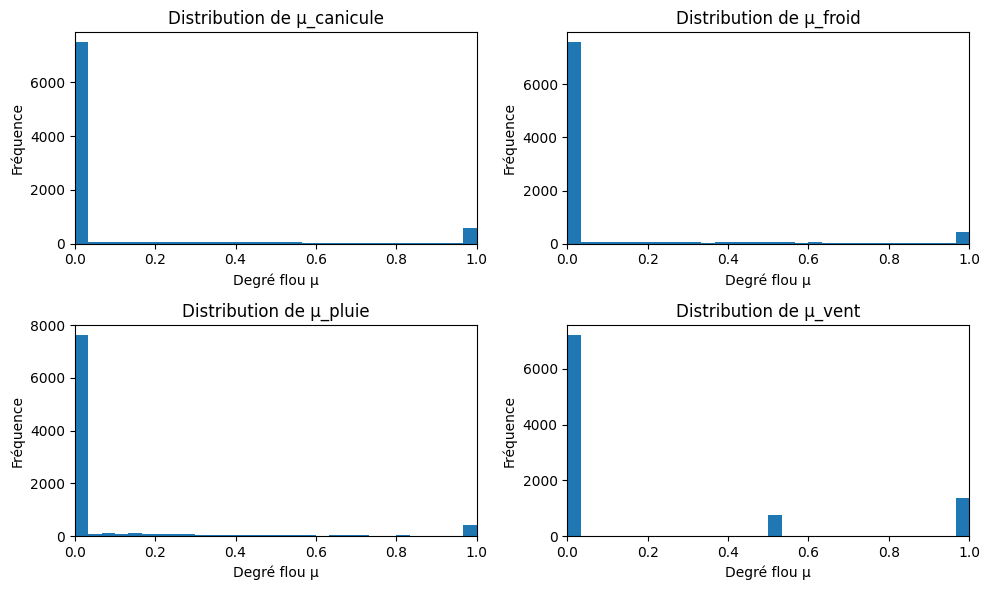

In [46]:
pdf_mu = df_daily.select(
    "mu_canicule",
    "mu_froid",
    "mu_pluie",
    "mu_vent"
).toPandas()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10,6))

axes[0,0].hist(pdf_mu["mu_canicule"], bins=30)
axes[0,0].set_title("Distribution de μ_canicule")

axes[0,1].hist(pdf_mu["mu_froid"], bins=30)
axes[0,1].set_title("Distribution de μ_froid")

axes[1,0].hist(pdf_mu["mu_pluie"], bins=30)
axes[1,0].set_title("Distribution de μ_pluie")

axes[1,1].hist(pdf_mu["mu_vent"], bins=30)
axes[1,1].set_title("Distribution de μ_vent")

for ax in axes.flatten():
    ax.set_xlim(0, 1)
    ax.set_xlabel("Degré flou μ")
    ax.set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

Agrégation floue → mu_extreme puis event_extreme

In [47]:
from pyspark.sql.functions import greatest, col

df_daily = df_daily.withColumn(
    "mu_extreme",
    greatest(
        col("mu_canicule"),
        col("mu_froid"),
        col("mu_pluie"),
        col("mu_vent")
    )
)


In [48]:
df_daily.select(
    "mu_canicule",
    "mu_froid",
    "mu_pluie",
    "mu_vent",
    "mu_extreme"
).show(5)


+-------------------+--------+--------+-------+-------------------+
|        mu_canicule|mu_froid|mu_pluie|mu_vent|         mu_extreme|
+-------------------+--------+--------+-------+-------------------+
|                0.0|     0.0|     1.0|    0.0|                1.0|
|                0.0|     0.0|     0.0|    0.0|                0.0|
|0.47727272727273024|     0.0|     0.0|    0.0|0.47727272727273024|
|                0.0|     0.0|     0.0|    0.0|                0.0|
|                1.0|     0.0|     0.0|    0.0|                1.0|
+-------------------+--------+--------+-------+-------------------+
only showing top 5 rows



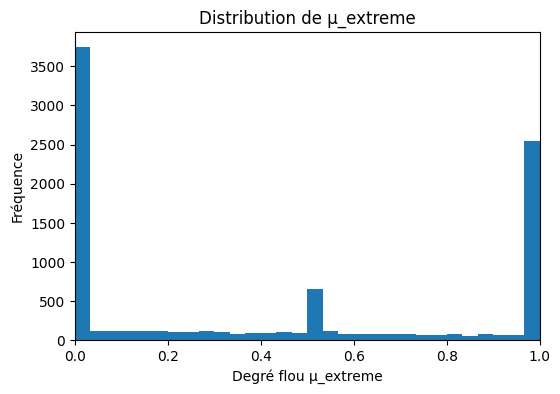

In [49]:
pdf_extreme = df_daily.select("mu_extreme").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(pdf_extreme["mu_extreme"], bins=30)
plt.xlabel("Degré flou μ_extreme")
plt.ylabel("Fréquence")
plt.title("Distribution de μ_extreme")
plt.xlim(0,1)
plt.show()


In [50]:
from pyspark.sql.functions import when

ALPHA = 0.5

df_daily = df_daily.withColumn(
    "event_extreme",
    (col("mu_extreme") >= ALPHA).cast("int")
)

In [51]:
df_daily.groupBy("event_extreme").count().show()

+-------------+-----+
|event_extreme|count|
+-------------+-----+
|            1| 4181|
|            0| 5187|
+-------------+-----+



In [52]:
df_daily.select(
    "mu_extreme", "event_extreme"
).show(5)


+-------------------+-------------+
|         mu_extreme|event_extreme|
+-------------------+-------------+
|                1.0|            1|
|                0.0|            0|
|0.47727272727273024|            0|
|                0.0|            0|
|                1.0|            1|
+-------------------+-------------+
only showing top 5 rows



In [53]:
df_daily.groupBy("event_extreme").count().show()


+-------------+-----+
|event_extreme|count|
+-------------+-----+
|            1| 4181|
|            0| 5187|
+-------------+-----+



Détection du type d’événement (type_event)

In [54]:
from pyspark.sql.functions import when, col

df_daily= df_daily.withColumn(
    "type_event",
    when(col("event_extreme") == 0, "normal")

    # Canicule dominante
    .when(
        (col("mu_canicule") >= col("mu_froid")) &
        (col("mu_canicule") >= col("mu_pluie")) &
        (col("mu_canicule") >= col("mu_vent")),
        "canicule"
    )

    # Froid dominant
    .when(
        (col("mu_froid") >= col("mu_pluie")) &
        (col("mu_froid") >= col("mu_vent")),
        "vague_froid"
    )

    # Pluie dominante
    .when(
        col("mu_pluie") >= col("mu_vent"),
        "forte_pluie"
    )

    # Vent dominant
    .otherwise("vent_fort")
)

In [55]:
df_daily.select(
    "mu_canicule", "mu_froid",
    "mu_pluie", "mu_vent",
    "mu_extreme",
    "event_extreme",
    "type_event"
).show(5)


+-------------------+--------+--------+-------+-------------------+-------------+-----------+
|        mu_canicule|mu_froid|mu_pluie|mu_vent|         mu_extreme|event_extreme| type_event|
+-------------------+--------+--------+-------+-------------------+-------------+-----------+
|                0.0|     0.0|     1.0|    0.0|                1.0|            1|forte_pluie|
|                0.0|     0.0|     0.0|    0.0|                0.0|            0|     normal|
|0.47727272727273024|     0.0|     0.0|    0.0|0.47727272727273024|            0|     normal|
|                0.0|     0.0|     0.0|    0.0|                0.0|            0|     normal|
|                1.0|     0.0|     0.0|    0.0|                1.0|            1|   canicule|
+-------------------+--------+--------+-------+-------------------+-------------+-----------+
only showing top 5 rows



In [56]:
df_daily.groupBy("type_event").count().show()


+-----------+-----+
| type_event|count|
+-----------+-----+
|  vent_fort| 1704|
|     normal| 5187|
|vague_froid|  845|
|forte_pluie|  562|
|   canicule| 1070|
+-----------+-----+



EDA basée sur la logique floue

In [57]:
sample_df = df_daily.toPandas()


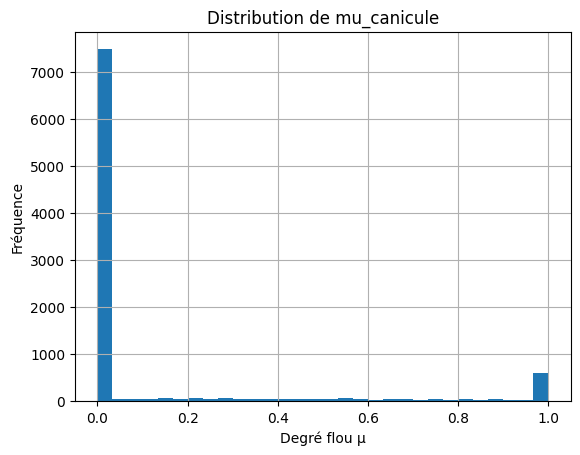

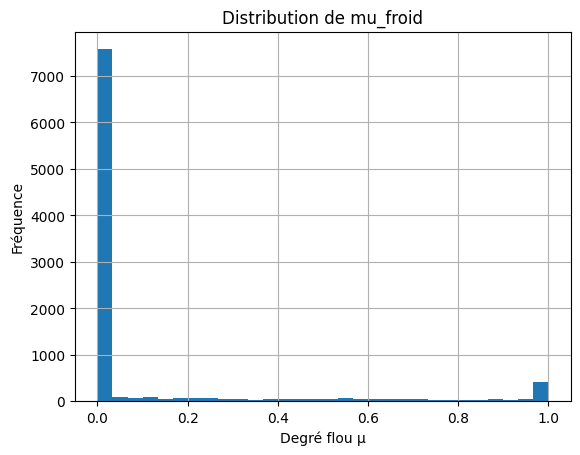

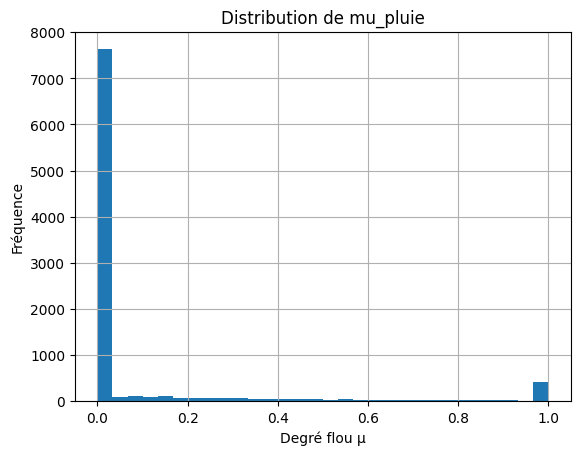

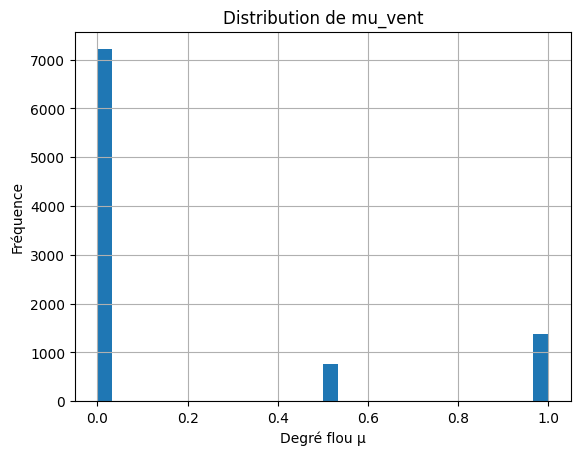

In [58]:
import matplotlib.pyplot as plt

mu_cols = ["mu_canicule", "mu_froid", "mu_pluie", "mu_vent"]

for c in mu_cols:
    plt.figure()
    sample_df[c].hist(bins=30)
    plt.title(f"Distribution de {c}")
    plt.xlabel("Degré flou μ")
    plt.ylabel("Fréquence")
    plt.show()


In [59]:
df_daily.coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("Dataset-final-weather.csv")


In [60]:
from pyspark.sql.functions import avg, min, max

df.groupBy("city").agg(
    avg("temperature").alias("avg_temperature"),
    min("temperature").alias("min_temperature"),
    max("temperature").alias("max_temperature"),

    avg("pressure").alias("avg_pressure"),
    min("pressure").alias("min_pressure"),
    max("pressure").alias("max_pressure"),

    avg("humidity").alias("avg_humidity"),
    min("humidity").alias("min_humidity"),
    max("humidity").alias("max_humidity"),

    avg("wind_speed").alias("avg_wind_speed"),
    min("wind_speed").alias("min_wind_speed"),
    max("wind_speed").alias("max_wind_speed")
).show(truncate=False)


+----------+------------------+-------------------+------------------+------------------+------------+------------+-----------------+------------+------------+------------------+--------------+--------------+
|city      |avg_temperature   |min_temperature    |max_temperature   |avg_pressure      |min_pressure|max_pressure|avg_humidity     |min_humidity|max_humidity|avg_wind_speed    |min_wind_speed|max_wind_speed|
+----------+------------------+-------------------+------------------+------------------+------------+------------+-----------------+------------+------------+------------------+--------------+--------------+
|Agadir    |17.695646270145176|-6.646333332999973 |42.32000000000005 |1015.8733175680155|886.0       |1044.0      |62.68723893296793|5.0         |100.0       |1.2178928989767277|0.0           |15.0          |
|Tetouan   |11.842929189358104|-10.779999999999973|39.370000000000005|1019.2681980906922|968.0       |1056.0      |74.66992619110758|10.0        |100.0       |2.050

In [61]:
import numpy as np

def mu_croissante(x, a, b):
    return np.clip((x - a) / (b - a), 0, 1)

def mu_decroissante(x, a, b):
    return np.clip((b - x) / (b - a), 0, 1)

def mu_triangulaire(x, a, b, c):
    return np.maximum(
        np.minimum((x - a) / (b - a), (c - x) / (c - b)),
        0
    )


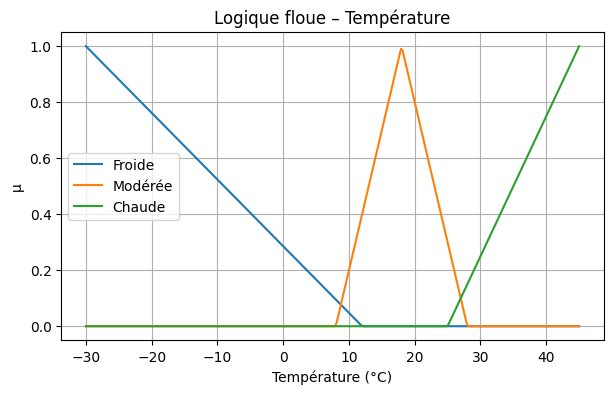

In [62]:
x_temp = np.linspace(-30, 45, 300)

mu_froide  = mu_decroissante(x_temp, -30, 12)
mu_moderee = mu_triangulaire(x_temp, 8, 18, 28)
mu_chaude  = mu_croissante(x_temp, 25, 45)

plt.figure(figsize=(7,4))
plt.plot(x_temp, mu_froide, label="Froide")
plt.plot(x_temp, mu_moderee, label="Modérée")
plt.plot(x_temp, mu_chaude, label="Chaude")
plt.xlabel("Température (°C)")
plt.ylabel("μ")
plt.title("Logique floue – Température")
plt.legend()
plt.grid(True)
plt.show()


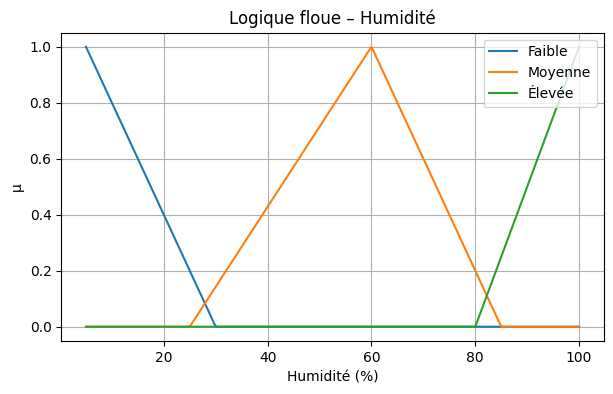

In [63]:
x_hum = np.linspace(5, 100, 300)

mu_faible  = mu_decroissante(x_hum, 5, 30)
mu_moyenne = mu_triangulaire(x_hum, 25, 60, 85)
mu_elevee  = mu_croissante(x_hum, 80, 100)

plt.figure(figsize=(7,4))
plt.plot(x_hum, mu_faible, label="Faible")
plt.plot(x_hum, mu_moyenne, label="Moyenne")
plt.plot(x_hum, mu_elevee, label="Élevée")
plt.xlabel("Humidité (%)")
plt.ylabel("μ")
plt.title("Logique floue – Humidité")
plt.legend()
plt.grid(True)
plt.show()


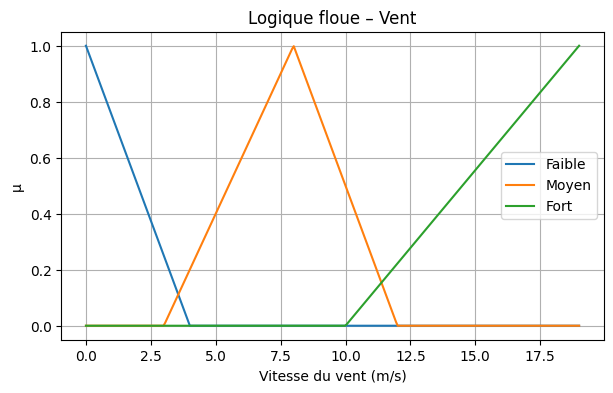

In [64]:
x_wind = np.linspace(0, 19, 300)

mu_faible_vent = mu_decroissante(x_wind, 0, 4)
mu_moyen_vent  = mu_triangulaire(x_wind, 3, 8, 12)
mu_fort_vent   = mu_croissante(x_wind, 10, 19)

plt.figure(figsize=(7,4))
plt.plot(x_wind, mu_faible_vent, label="Faible")
plt.plot(x_wind, mu_moyen_vent, label="Moyen")
plt.plot(x_wind, mu_fort_vent, label="Fort")
plt.xlabel("Vitesse du vent (m/s)")
plt.ylabel("μ")
plt.title("Logique floue – Vent")
plt.legend()
plt.grid(True)
plt.show()


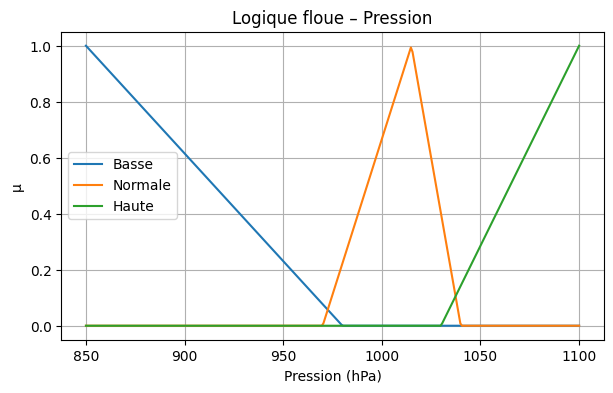

In [65]:
x_pres = np.linspace(850, 1100, 300)

mu_basse   = mu_decroissante(x_pres, 850, 980)
mu_normale = mu_triangulaire(x_pres, 970, 1015, 1040)
mu_haute   = mu_croissante(x_pres, 1030, 1100)

plt.figure(figsize=(7,4))
plt.plot(x_pres, mu_basse, label="Basse")
plt.plot(x_pres, mu_normale, label="Normale")
plt.plot(x_pres, mu_haute, label="Haute")
plt.xlabel("Pression (hPa)")
plt.ylabel("μ")
plt.title("Logique floue – Pression")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
df.show(5)


+-------------------+------+------------------+--------+--------+----------+--------------+-----+------+
|           datetime|  city|       temperature|humidity|pressure|wind_speed|wind_direction|month|season|
+-------------------+------+------------------+--------+--------+----------+--------------+-----+------+
|2012-10-01 13:00:00|Agadir|18.720000000000027|    88.0|  1013.0|       0.0|           0.0|   10|autumn|
|2012-10-01 14:00:00|Agadir|      18.718185522|    88.0|  1013.0|       0.0|           0.0|   10|autumn|
|2012-10-01 15:00:00|Agadir|18.712844458999996|    88.0|  1013.0|       0.0|           0.0|   10|autumn|
|2012-10-01 16:00:00|Agadir|18.707503395000003|    88.0|  1013.0|       0.0|           0.0|   10|autumn|
|2012-10-01 17:00:00|Agadir|      18.702162332|    88.0|  1013.0|       0.0|           0.0|   10|autumn|
+-------------------+------+------------------+--------+--------+----------+--------------+-----+------+
only showing top 5 rows



In [67]:
df.head()


Row(datetime=datetime.datetime(2012, 10, 1, 13, 0), city='Agadir', temperature=18.720000000000027, humidity=88.0, pressure=1013.0, wind_speed=0.0, wind_direction=0.0, month=10, season='autumn')

In [68]:
from pyspark.sql.functions import col

df = df.withColumn("datetime", col("datetime").cast("string"))


In [69]:
df_pandas = df.toPandas()
df_pandas.head()


,datetime,city,temperature,humidity,pressure,wind_speed,wind_direction,month,season
0,2012-10-01 13:00:00,Agadir,18.720000,88.0,1013.0,0.0,0.0,10,autumn
1,2012-10-01 14:00:00,Agadir,18.718186,88.0,1013.0,0.0,0.0,10,autumn
2,2012-10-01 15:00:00,Agadir,18.712844,88.0,1013.0,0.0,0.0,10,autumn
3,2012-10-01 16:00:00,Agadir,18.707503,88.0,1013.0,0.0,0.0,10,autumn
4,2012-10-01 17:00:00,Agadir,18.702162,88.0,1013.0,0.0,0.0,10,autumn


In [70]:
import pandas as pd

df_pandas = pd.read_csv(
    r"C:\Users\Lenovo\Downloads\Projett_globale_Modele\DATASETWIJDANE.csv"
)

df_pandas.head()


,city,date,temp_mean,humidity_mean,pressure_mean,wind_mean,temp_max,wind_max,mu_canicule,mu_froid,mu_vent,mu_pluie,mu_depression,mu_extreme,event_extreme,type_event
0,Tetouan,2014-10-08,15.556375,80.625000,1026.458333,0.375000,21.601333,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0,normal
1,Agadir,2016-11-25,16.247500,24.208333,1018.250000,1.250000,24.460000,3.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0,normal
2,Tetouan,2013-07-31,17.319167,76.291667,1017.041667,0.958333,25.350000,2.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0,normal
3,Agadir,2013-11-06,13.803420,27.875000,1026.250000,0.750000,27.950000,2.0,0.477273,0.0,0.0,0.0,0.0,0.477273,0,normal
4,Agadir,2014-07-31,24.734213,72.541667,1013.291667,2.125000,30.210000,5.0,0.944215,0.0,0.0,0.0,1.0,0.944215,1,canicule


In [71]:
df_pandas["type_event"].value_counts()


type_event
normal         5188
vent_fort      1704
canicule       1070
vague_froid     845
forte_pluie     561
Name: count, dtype: int64

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# labels originaux sous forme 1D
labels = df_pandas['type_event'].values  # shape (n_samples,)

# encoder en 0..4
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)  # shape (n_samples,)

# convertir en one-hot
y_train = to_categorical(labels_encoded, num_classes=5)  # shape (n_samples, 5)
print(y_train.shape)  # doit afficher (n_samples,5)


(9368, 5)


In [74]:
# 1️⃣ Importer les librairies
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 2️⃣ Préparer les données
# -------------------------------
from sklearn.preprocessing import LabelEncoder

city_encoder = LabelEncoder()
df_pandas['city_encoded'] = city_encoder.fit_transform(df_pandas['city'])

df_pandas['date'] = pd.to_datetime(df_pandas['date'])

df_pandas['year'] = df_pandas['date'].dt.year
df_pandas['month'] = df_pandas['date'].dt.month
df_pandas['day'] = df_pandas['date'].dt.day

# Exemple : df_pandas = ton dataframe
# Assurer que tes features sont numériques
features = [
    'city_encoded',
    'temp_mean',
    'humidity_mean',
    'pressure_mean',
    'wind_mean',
    'month',
    'day'
]


X = df_pandas[features].values
y_labels = df_pandas['type_event'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LSTM shape
X_train = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Encoder les labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
y_train = to_categorical(y_encoded, num_classes=len(le.classes_))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# -------------------------------
# 3️⃣ Créer le modèle LSTM
# -------------------------------

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (timesteps, features)
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------
# 4️⃣ Entraîner le modèle
# -------------------------------

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=158,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# -------------------------------
# 5️⃣ Évaluer l’accuracy finale
# -------------------------------

loss, accuracy = model.evaluate(X_train, y_train)
print(f"Accuracy finale sur le training set : {accuracy:.4f}")


X_train shape: (9368, 1, 7)
y_train shape: (9368, 5)
Epoch 1/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5376 - loss: 1.3173 - val_accuracy: 0.7663 - val_loss: 0.6491
Epoch 2/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7565 - loss: 0.6440 - val_accuracy: 0.8138 - val_loss: 0.4811
Epoch 3/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7864 - loss: 0.5290 - val_accuracy: 0.8298 - val_loss: 0.4239
Epoch 4/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8096 - loss: 0.4709 - val_accuracy: 0.8367 - val_loss: 0.4072
Epoch 5/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8221 - loss: 0.4575 - val_accuracy: 0.8378 - val_loss: 0.3997
Epoch 6/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8243 - loss: 0.4449 - val_accuracy: 0.8367 - val_loss: 0.3921
Epoch 7/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8299 - loss: 0.4264 - val_accuracy: 0.8495 - val_loss: 0.3904
Epoch 8/158
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [86]:
new_data_pluie_extreme = {
    'city': ['Tetouan'],
    'date': ['2026-02-10'],      # hiver = période favorable aux pluies
    'temp_mean': [12.5],         # température modérée
    'humidity_mean': [95.0],     # humidité très élevée
    'pressure_mean': [998.0],    # pression basse → perturbation
    'wind_mean': [6.8]           # vent modéré à fort
}

new_df = pd.DataFrame(new_data_pluie_extreme)


In [87]:
new_df['city_encoded'] = city_encoder.transform(new_df['city'])


In [88]:
new_df['date'] = pd.to_datetime(new_df['date'])

new_df['month'] = new_df['date'].dt.month
new_df['day'] = new_df['date'].dt.day


In [89]:
print(new_df.columns)


Index(['city', 'date', 'temp_mean', 'humidity_mean', 'pressure_mean',
       'wind_mean', 'city_encoded', 'month', 'day'],
      dtype='object')


In [90]:
features = [
    'city_encoded',
    'temp_mean',
    'humidity_mean',
    'pressure_mean',
    'wind_mean',
    'month',
    'day'
]

X_new = new_df[features].values


In [91]:
X_new_scaled = scaler.transform(X_new)


In [92]:
X_new_scaled = X_new_scaled.reshape(1, 1, X_new_scaled.shape[1])


In [93]:
y_pred = model.predict(X_new_scaled)
pred_class = np.argmax(y_pred, axis=1)

event_pred = le.inverse_transform(pred_class)

print("🌪️ Événement prédit :", event_pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
🌪️ Événement prédit : forte_pluie


In [94]:
tests = pd.DataFrame([
    ['Tetouan', '2026-02-10', 12.5, 95, 998, 6.8],
    ['Tetouan', '2026-01-28', 10.8, 98, 992, 9.5],
    ['Tetouan', '2026-03-05', 15.0, 80, 1008, 3.5],
], columns=['city','date','temp_mean','humidity_mean','pressure_mean','wind_mean'])


In [95]:
# Sauvegarde complète du modèle
model.save("lstm_extreme_event_model2.h5")
print("Modèle enregistré dans lstm_extreme_event_model.h5")


Modèle enregistré dans lstm_extreme_event_model.h5


In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np


In [97]:
from sklearn.model_selection import train_test_split

# Séparer train et test
df_train, df_test = train_test_split(df_pandas, test_size=0.2, random_state=42, stratify=df_pandas['type_event'])


In [98]:
X_test = df_test[features].values
y_test_labels = df_test['type_event'].values

X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

y_test_encoded = le.transform(y_test_labels)
y_test_onehot = to_categorical(y_test_encoded, num_classes=len(le.classes_))

loss, accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f"Accuracy sur le test set : {accuracy:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3358
Accuracy sur le test set : 0.8735


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


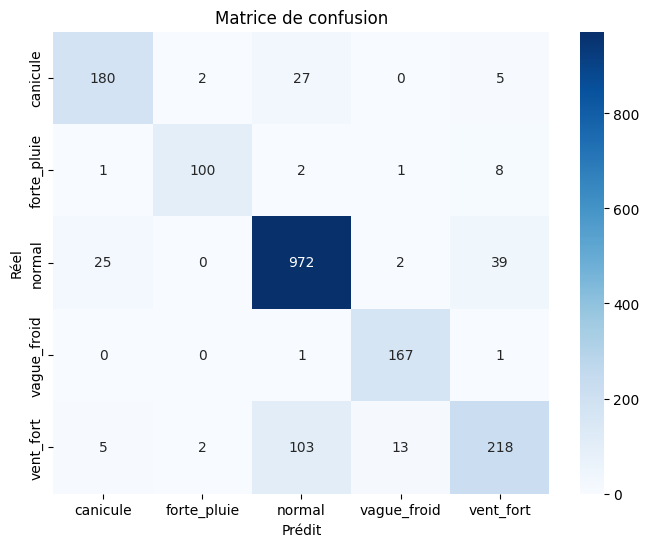

              precision    recall  f1-score   support

    canicule       0.85      0.84      0.85       214
 forte_pluie       0.96      0.89      0.93       112
      normal       0.88      0.94      0.91      1038
 vague_froid       0.91      0.99      0.95       169
   vent_fort       0.80      0.64      0.71       341

    accuracy                           0.87      1874
   macro avg       0.88      0.86      0.87      1874
weighted avg       0.87      0.87      0.87      1874



In [99]:
# -------------------------------
# 7️⃣ Matrice de confusion
# -------------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions du modèle
y_pred_prob = model.predict(X_test_scaled)  # prédictions en probabilités
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # récupérer l'indice de la classe prédite

# Vraies classes
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Créer la matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Affichage avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# Optionnel : rapport de classification
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))
